In [ ]:
import tensorflow as tf
import pathlib
from google.colab import drive
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
from keras.optimizers import Adam
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [ ]:
#define constants
HIGH_RES = 224
LOW_RES = 112

N_TRAIN = 1152
N_VAL = 384
N_TEST = 512

batch_size = 16

#images stored in google drive in separate files for low and high resolution
high_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/high_res_images')
low_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/low_res_images')

high_res_paths = sorted([str(path) for path in high_res_dir.glob('*.jpg')])
low_res_paths = sorted([str(path) for path in low_res_dir.glob('*.jpg')])

#training, validation and test split
train_high_res_paths = high_res_paths[:N_TRAIN]
train_low_res_paths = low_res_paths[:N_TRAIN]

val_high_res_paths = high_res_paths[N_TRAIN:N_TRAIN+N_VAL]
val_low_res_paths = low_res_paths[N_TRAIN:N_TRAIN+N_VAL]

test_high_res_paths = high_res_paths[N_TRAIN+N_VAL:]
test_low_res_paths = low_res_paths[N_TRAIN+N_VAL:]

#define function for scaling in the range [-1,1]
def normalize_images(low_res_img, high_res_img):
    """Normalize images."""
    low_res_img = tf.cast(low_res_img, dtype=tf.float32) / 127.5 - 1.0
    high_res_img = tf.cast(high_res_img, dtype=tf.float32) / 127.5 - 1.0

    return low_res_img, high_res_img

#decode images, scale LR images and normalize in correct range
def train_preprocessing(low_res_path, high_res_path):
    """Preprocessing steps for each image pair."""
    low_res_img = tf.io.read_file(low_res_path)
    low_res_img = tf.image.decode_jpeg(low_res_img, channels=3)
    high_res_img = tf.io.read_file(high_res_path)
    high_res_img = tf.image.decode_jpeg(high_res_img, channels=3)

    #resize LR-images using bicubic interpolation
    low_res_img = tf.image.resize(low_res_img, [HIGH_RES, HIGH_RES], method=tf.image.ResizeMethod.BICUBIC)

    low_res_img, high_res_img = normalize_images(low_res_img, high_res_img)

    return low_res_img, high_res_img

#create datasets
def create_dataset(low_res_paths, high_res_paths, batch_size, is_training=True):
    """Create Datasets"""
    ds = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
    ds = ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(buffer_size=len(low_res_paths))
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = create_dataset(train_low_res_paths, train_high_res_paths, batch_size, is_training=True)
val_ds = create_dataset(val_low_res_paths, val_high_res_paths, batch_size, is_training=False)
test_ds = create_dataset(test_low_res_paths, test_high_res_paths, batch_size, is_training=False)

### Model definition

In [ ]:
#define model
def create_srcnn_model(L1=0.0, L2=0.0, dropout_rate=0.0):
  """
  Create SRCNN model.

  Args:
    L1 (float): L1 regularization parameter.
    L2 (float): L2 regularization parameter.
    dropout_rate (float): Dropout rate.

  Returns:
    Model: SRCNN model.
  """
  inputs = Input(shape=(HIGH_RES, HIGH_RES, 3))

  x = Conv2D(128, (9, 9), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=L1, l2=L2))(inputs)
  x = Dropout(dropout_rate)(x)

  x = Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=L1, l2=L2))(x)
  x = Dropout(dropout_rate)(x)

  x = Conv2D(3, (5, 5), activation='linear', padding='same')(x)

  return Model(inputs, outputs=x)

In [ ]:
# Create the model instance with specified regularization and dropout rates
model = create_srcnn_model(L1=0.00, L2=0.00, dropout_rate=0.01)

adam_optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['accuracy'])

## Train model

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
72/72 [==============================] - 14s 146ms/step - loss: 0.0250 - accuracy: 0.8188 - val_loss: 0.0078 - val_accuracy: 0.8945
Epoch 2/50
72/72 [==============================] - 13s 145ms/step - loss: 0.0068 - accuracy: 0.8765 - val_loss: 0.0043 - val_accuracy: 0.9054
Epoch 3/50
72/72 [==============================] - 13s 147ms/step - loss: 0.0058 - accuracy: 0.8850 - val_loss: 0.0062 - val_accuracy: 0.8133
Epoch 4/50
72/72 [==============================] - 13s 145ms/step - loss: 0.0047 - accuracy: 0.8804 - val_loss: 0.0030 - val_accuracy: 0.9248
Epoch 5/50
72/72 [==============================] - 13s 145ms/step - loss: 0.0033 - accuracy: 0.9006 - val_loss: 0.0026 - val_accuracy: 0.9234
Epoch 6/50
72/72 [==============================] - 13s 144ms/step - loss: 0.0029 - accuracy: 0.9048 - val_loss: 0.0024 - val_accuracy: 0.9323
Epoch 7/50
72/72 [==============================] - 13s 144ms/step - loss: 0.0028 - accuracy: 0.9075 - val_loss: 0.0023 - val_accuracy: 0.9208

In [ ]:
model.save_weights('/content/drive/MyDrive/SRCNN_weights.h5' )

# Inference

In [ ]:
#load weights
model = create_srcnn_model(L1=0.00, L2=0.00, dropout_rate=0.01)
adam_optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/ST456_project_team_afi/0_SRCNN_final/SRCNN_weights.h5')

In [ ]:
#perform inference on test set
image_data = []

for low_res, high_res in test_ds:
    sr_batch = model.predict(low_res)
    for lr_img, sr_img, hr_img in zip(low_res.numpy(), sr_batch, high_res.numpy()):
        image_data.append((lr_img, sr_img, hr_img))

1/1 [==============================] - 0s 24ms/step


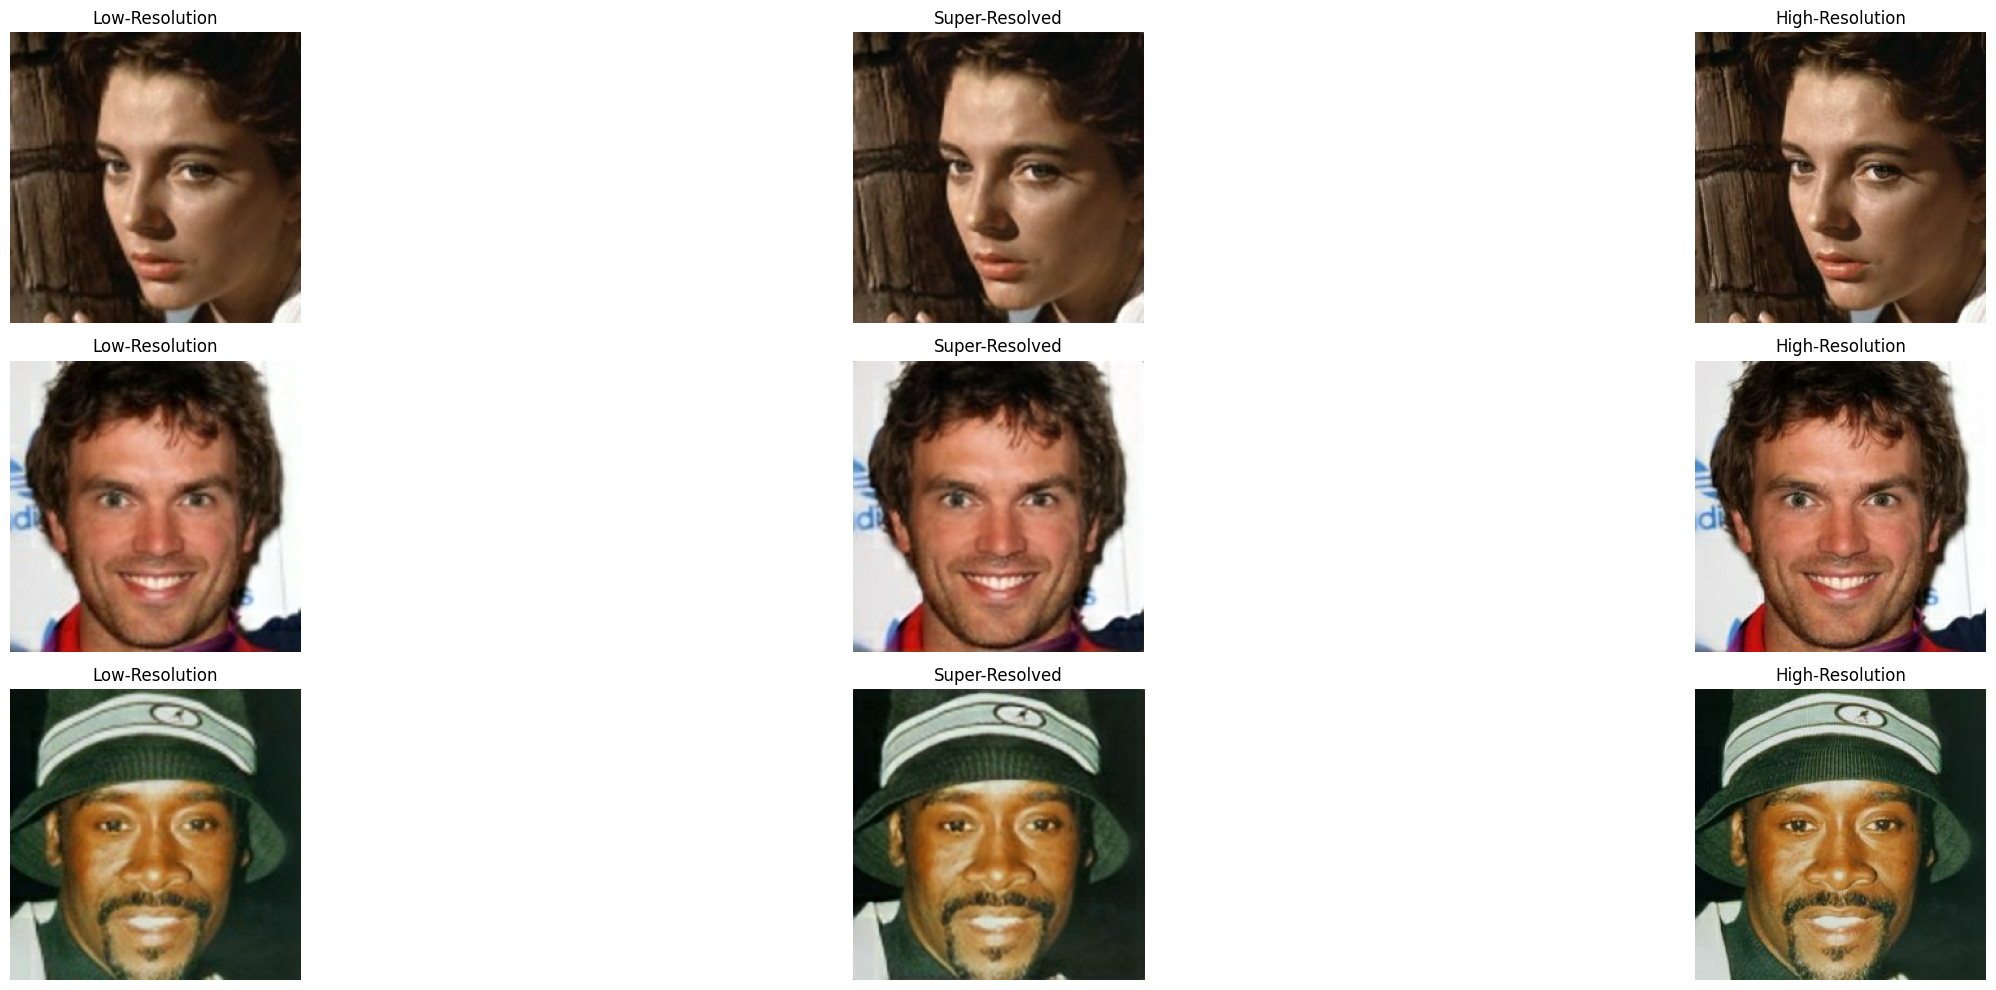

In [ ]:
#plot first test images with LR, SR and HR image

def plot_images(image_data, n_images, figsize=(30, 10)):
  """
  Plot images.

  Args:
    image_data (list): List of image data.
    n_images (int): Number of images to plot.
    figsize (tuple): Figure size.
  """
  plt.figure(figsize=figsize)
  titles = ['Low-Resolution', 'Super-Resolved', 'High-Resolution']
  for i in range(n_images):
      lr_img, sr_img, hr_img = image_data[i]
      images = [lr_img, sr_img, hr_img]

      for j, img in enumerate(images):
          img_normalized = np.clip((img + 1) * 0.5, 0, 1)
          plt.subplot(n_images, 3, i * 3 + j + 1)
          plt.imshow(img_normalized)
          plt.title(titles[j])
          plt.axis('off')

  plt.tight_layout()
  plt.show()

plot_images(image_data, n_images=3)

In [ ]:
def evaluate_metrics(image_data):
    psnr_values = []
    ssim_values = []

    for lr_img, sr_img, hr_img in image_data:
        psnr = tf.image.psnr(hr_img, sr_img, max_val=1.0)
        ssim = tf.image.ssim(hr_img, sr_img, max_val=1.0)

        psnr_values.append(psnr.numpy())
        ssim_values.append(ssim.numpy())

    return psnr_values, ssim_values

psnr_values, ssim_values = evaluate_metrics(image_data)
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")

Average PSNR: 27.33 dB
Average SSIM: 0.8748


### XAI: Saliency Map

In [ ]:
def calc_saliency(model, low_res_image, high_res_image):
  """
  Calculate saliency map.

  Args:
    model (Model): SRCNN model.
    low_res_image (Tensor): Low-resolution image.
    high_res_image (Tensor): High-resolution image.

  Returns:
    Tensor: Normalized saliency map.
  """
  with tf.GradientTape() as tape:
      tape.watch(low_res_image)
      sr_image = model(low_res_image, training=False)
      #calculate MSE between SR and HR
      loss = tf.reduce_mean(tf.square(high_res_image - sr_image))

  #calculate gradients of loss with respect to input image
  gradient = tape.gradient(loss, low_res_image)
  gradient = tf.reduce_max(tf.abs(gradient), axis=-1)
  saliency_map = gradient.numpy()

  #normalise for visualisation
  min_val, max_val = np.min(saliency_map), np.max(saliency_map)
  saliency_map_normalized = (saliency_map - min_val) / (max_val - min_val + np.finfo(float).eps)

  return saliency_map_normalized


1/1 [==============================] - 0s 28ms/step


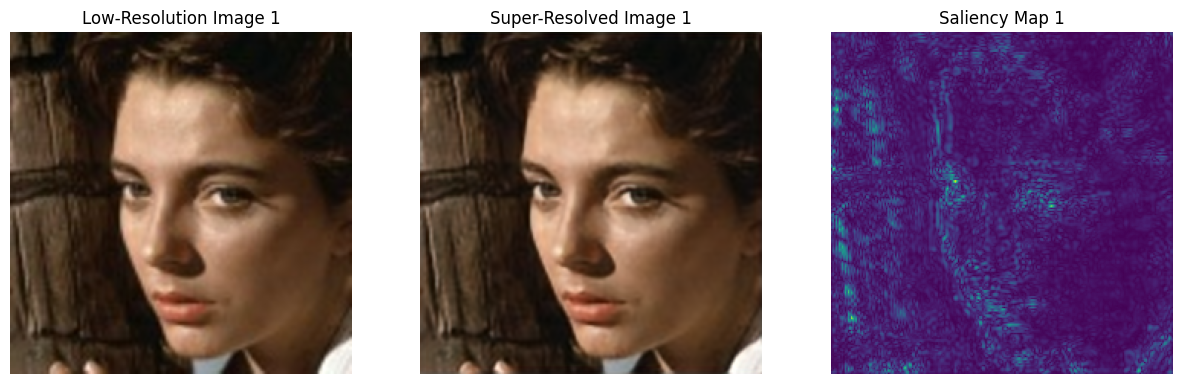

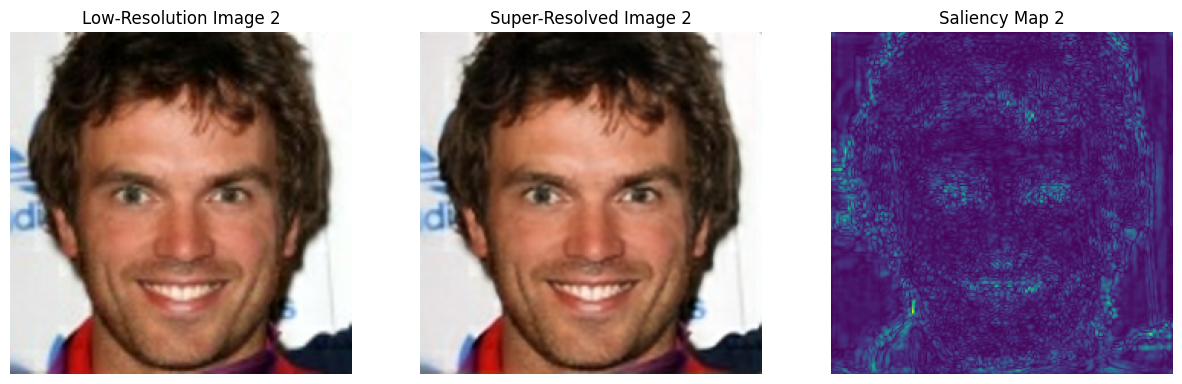

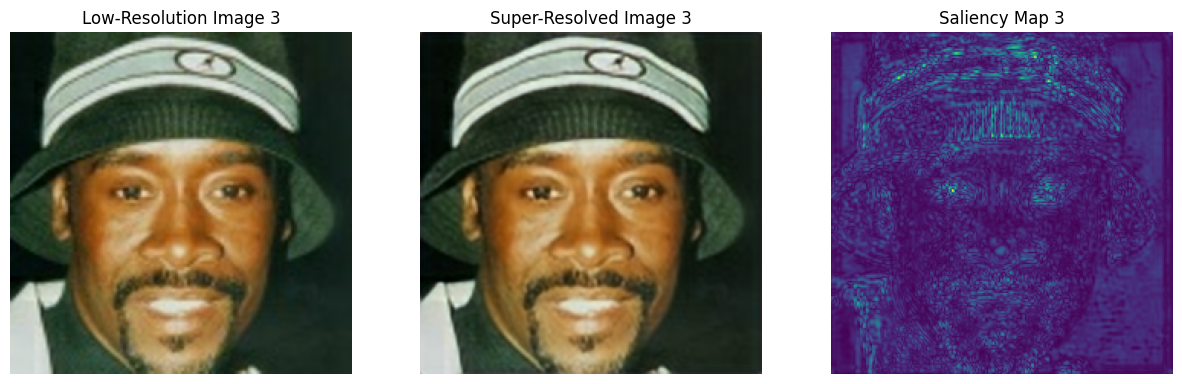

In [ ]:
#apply to first 3 images of first test batch
low_res_batch, high_res_batch = next(iter(test_ds))
sr_batch = model.predict(low_res_batch)

for i in range(3):
    low_res_image = tf.expand_dims(low_res_batch[i], axis=0)
    high_res_image = tf.expand_dims(high_res_batch[i], axis=0)

    saliency_map = calc_saliency(model, low_res_image, high_res_image)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    low_res_img = (low_res_batch[i].numpy() + 1) * 0.5
    low_res_img_clipped = np.clip(low_res_img, 0, 1)
    plt.imshow(low_res_img_clipped)
    plt.title(f'Low-Resolution Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    sr_img = (sr_batch[i] + 1) * 0.5
    sr_img_clipped = np.clip(sr_img, 0, 1)
    plt.imshow(sr_img_clipped)
    plt.title(f'Super-Resolved Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(saliency_map[0])
    plt.title(f'Saliency Map {i+1}')
    plt.axis('off')

    plt.show()

In [ ]:
model.load_weights("/content/drive/MyDrive/ST456_project_team_afi/0_SRCNN_final/SRCNN_weights.h5")
model.save("/content/drive/MyDrive/ST456_project_team_afi/0_SRCNN_final/SRCNN.keras")